In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
dataset = pd.read_csv("stars_data.csv", header=0)

### Popis datasetu

* Temperature (°K)
* L - relative luminosity (L/Lo)
* R - relative radius (R/Ro)
* A_M - absolute magnitude (Mv)
* Color - general color of spectrum
* Spectral_Class - O,B,A,F,G,K,M / SMASS
* Type - Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants

------
```
Lo = 3.828 * 10^26 W
Ro = 6.9551 * 10^8 m
```

In [3]:
dataset.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [4]:
dataset.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


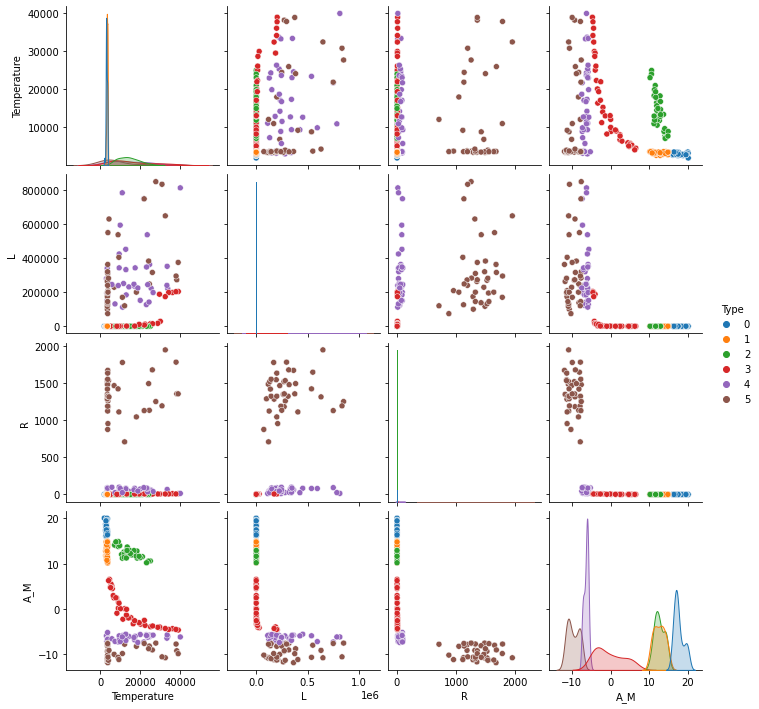

In [8]:
sns.pairplot(dataset, hue="Type", palette="tab10")